<a href="https://colab.research.google.com/github/ysrael12/Luna16/blob/main/Luna16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Processamento de Dados

In [52]:
!ls ../root/.cache/kagglehub/datasets/avc0706/luna16/versions/1/seg-lungs-LUNA16/seg-lungs-LUNA16

annotations.csv  candidates_V2	   sampleSubmission.csv  subset0  subset2
candidates.csv	 evaluationScript  seg-lungs-LUNA16	 subset1  subset3


In [ ]:
../root/.cache/kagglehub/datasets/avc0706/luna16/versions/1/subset0

In [ ]:
!pip install imageio==2.23.0
!pip install pillow==10.0.0

In [2]:
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
import os
import seaborn as sn

Download do data set

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("avc0706/luna16")

print("Path to dataset files:", path)

KeyboardInterrupt: 

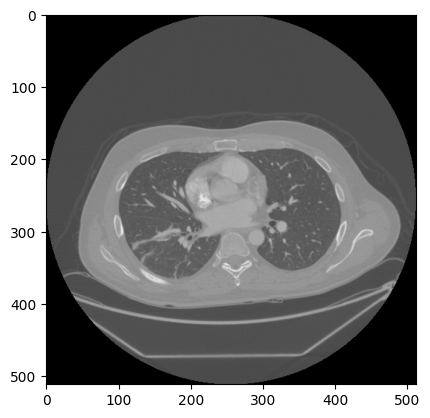

In [8]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def read_mhd_raw(mhd_path):
    # Read the .mhd file
    mhd_image = sitk.ReadImage(mhd_path)

    # Get metadata
    dimensions = mhd_image.GetSize()      # This returns a tuple of image dimensions (e.g., (512, 512, 100))
    data_type = mhd_image.GetPixelID()
    spacing = mhd_image.GetSpacing()

    # Map SimpleITK pixel type to NumPy data type
    pixel_type_mapping = {
        sitk.sitkInt16: np.int16,
        sitk.sitkUInt16: np.uint16,
        sitk.sitkInt32: np.int32,
        sitk.sitkUInt32: np.uint32,
        sitk.sitkFloat32: np.float32,
        sitk.sitkFloat64: np.float64,
        # Add other mappings as needed
    }

    numpy_data_type = pixel_type_mapping.get(data_type)

    if numpy_data_type is None:
        raise ValueError(f"Unsupported SimpleITK pixel type: {data_type}")

    # Read the .raw file as a NumPy array
    raw_path = mhd_path.replace('.mhd', '.raw')
    with open(raw_path, 'rb') as f:
        raw_data = np.fromfile(f, dtype=numpy_data_type)  # Use the mapped data type

    # Reshape the NumPy array to the correct image dimensions
    image_array = raw_data.reshape(dimensions[::-1])  # Reverse dimensions for SimpleITK

    # Create a SimpleITK Image
    image = sitk.GetImageFromArray(image_array)
    image.SetSpacing(spacing)

    return image


In [10]:
# Directory containing the .mhd files
data_dir = '../root/.cache/kagglehub/datasets/avc0706/luna16/versions/1/subset0/subset0'

# Iterate through the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.mhd'):
        filepath = os.path.join(data_dir, filename)

        # Read the image using the function
        image = read_mhd_raw(filepath)

        # Get the image data as a NumPy array
        image_array = sitk.GetArrayFromImage(image)

        # Select the middle slice
        slice_index = image_array.shape[0] // 2
        slice_to_display = image_array[slice_index, :, :]



In [35]:
anotations_csv = pd.read_csv('../root/.cache/kagglehub/datasets/avc0706/luna16/versions/1/annotations.csv')
candidates_csv = pd.read_csv('../root/.cache/kagglehub/datasets/avc0706/luna16/versions/1/candidates.csv')


combined_df = pd.merge(anotations_csv, candidates_csv, on=['seriesuid', 'coordX', 'coordY', 'coordZ'], how='outer')

def filter_subset(data_dir):
  # Obtenha uma lista de todos os arquivos .mhd no diretório
  mhd_files = [f for f in os.listdir(data_dir) if f.endswith('.mhd')]

  # Extraia os seriesuids dos nomes dos arquivos .mhd
  seriesuids = [f[:-4] for f in mhd_files]  # Remove a extensão .mhd

  # Filtre o DataFrame para incluir apenas as linhas com seriesuids presentes na lista
  filtered_df = combined_df[combined_df['seriesuid'].isin(seriesuids)]
  return filtered_df

filtered_df = filter_subset(data_dir)



In [36]:
def data_generator(df, batch_size=32):
    """
    Gera batches de dados para treinamento.

    Args:
        df: DataFrame combinado com informações sobre as imagens e rótulos.
        batch_size: Tamanho do batch.

    Yields:
        Tupla contendo um batch de imagens e um batch de rótulos.
    """
    num_samples = len(df)
    while True:
        # Embaralha o DataFrame a cada época
        df = df.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            batch_df = df[offset:offset + batch_size]
            images = []
            labels = []
            for index, row in batch_df.iterrows():
                seriesuid = row['seriesuid']
                mhd_path = os.path.join(data_dir, f"{seriesuid}.mhd")
                try:
                    image = read_mhd_raw(mhd_path)
                    image_array = sitk.GetArrayFromImage(image)

                    images.append(image_array)
                    labels.append(row['class'])

                except Exception as e:
                    print(f"Erro ao ler {mhd_path}: {e}")
                    continue  # Pula para o próximo arquivo se houver um erro

            # Converte as listas de imagens e rótulos para arrays NumPy
            images = np.array(images)
            labels = np.array(labels)

            yield images, labels

#Rede neural

In [43]:
import SimpleITK as sitk

# Carregue o arquivo .mhd usando SimpleITK
seriesuid = filtered_df['seriesuid'].iloc[0]  # Pegue o seriesuid da primeira linha do DataFrame
mhd_path = os.path.join(data_dir, f"{seriesuid}.mhd")
mhd_image = sitk.ReadImage(mhd_path)

# Obtenha as dimensões da imagem
dimensoes = mhd_image.GetSize()

input_shape = (dimensoes[2], dimensoes[1], dimensoes[0], 1)  # Ajuste a ordem das dimensões e o número de canais

print("Input shape:", input_shape)



Input shape: (121, 512, 512, 1)
